# Recurrent Neural Network to generate (predict) text data using Keras
* LSTM (Long Short-Term Memory) Network
* Code based on this article https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
* Data: full text of Alice in Wonderland taken from https://archive.org/stream/alicesadventures19033gut/19033.txt

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Masking
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# SOURCE: https://archive.org/stream/alicesadventures19033gut/19033.txt
text = open('Alice_in_Wonderland.txt').read().split(' ')

# Use Tokenizer class to turn text into numeric data

In [3]:
# set num_words to some int value to reduce size of label array, and number of params in last layer of model
tokenizer = Tokenizer(num_words=None, char_level=False, split=' ')
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
# for some reason, tokenizer returns sequences
flat_seq = []
for sub_arr in sequences:
    for item in sub_arr:
        flat_seq.append(item)
seq = np.array(flat_seq, dtype=np.int32)
print(seq[:10])
print(len(seq), 'total words')

[ 10   8 336   4  81  28 337   6 246  58]
9732 total words


In [4]:
print(len(tokenizer.index_word), ' words in the dictionary') # number of unique words
print([tokenizer.index_word[i] for i in range(1,10)]) # first ten words in dictionary (indexing starts at 1)

1522  words in the dictionary
['the', 'and', 'a', 'to', 'she', 'of', 'it', 'was', 'in']


# Prepare training data and labels
* Features (model input): 50 consecutive words from the text
* Labels (model output): The next word in that sequence

In [5]:
features = []
labels = []

training_len = 50

for i in range(training_len, len(seq)):
    # sub_seq has length of trainin_len + 1
    sub_seq = seq[i-training_len : i+1]
    features.append(sub_seq[:-1]) # all but last word
    labels.append(sub_seq[-1]) # last word in sub-sequence

# hold on to sorted data/labels for text generation after we train the model
X_sorted, y_sorted = np.array(features, dtype=np.float32), np.array(labels, dtype=np.float32)
# use shuffled data for training and testing
X,y = shuffle(X_sorted, y_sorted)

print(X.shape, y.shape)
print(X[0], y[0])

print([tokenizer.index_word[i] for i in X[0]], 
      tokenizer.index_word[y[0]])

(9682, 50) (9682,)
[  2.   5. 162.  18.  21. 944. 116.   4.   1.  22.  64.  27. 352.   1.
  22.  64.   8. 430.  53.   2.   1.  22. 256. 183.   8. 361.  20.   1.
 182. 123.  16. 141. 374.  86. 945. 199. 224.  82.   1. 167. 610.  26.
  12. 147.   8.  32. 227.  16.  25. 141.] 147.0
['and', 'she', 'ran', 'with', 'all', 'speed', 'back', 'to', 'the', 'little', 'door', 'but', 'alas', 'the', 'little', 'door', 'was', 'shut', 'again', 'and', 'the', 'little', 'golden', 'key', 'was', 'lying', 'on', 'the', 'glass', 'table', 'as', 'before', 'things', 'are', 'worse', 'than', 'ever', 'thought', 'the', 'poor', 'child', 'for', 'i', 'never', 'was', 'so', 'small', 'as', 'this', 'before'] never


# One-Hot encoding of labels, Train/Test split
* One-hot scheme: 3 == [0 0 0 1 0 ... 0] 
* Binary array represents class probabilities (each unique word is a class)
* NOTE: the one-hot encoding will take up significantly more memory than the integer representation of labels. To reduce the size of the encoded labels, set the `num_words` parameter in the Tokenizer object. This will also reduce the number of parameters in the final layer

In [6]:
# + 1 because word dictionary indexing starts at 1
n_words = len(tokenizer.index_word) + 1

# one-hot encoding for labels
y_onehot = to_categorical(y, n_words)
#print(list(y_onehot[0]).index(1), y[0]) # these two should be the same int value
#print(y_onehot.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7745, 50) (7745, 1523)
(1937, 50) (1937, 1523)


# Handling label imbalance by creating a dictionary of class weights
* The most common words are much more common than the vast majority of less common. This leads to a network which is heavily biased towards those words, and only produces them
* To combat this, we can assign more weight during training to instances whose labels are less common (not when testing/predicting)
* Using keras, we can pass in a `class_weight` dictionary to the `fit()` method

In [7]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
print(class_weights)

[0.0101945  0.0191032  0.02338738 ... 6.36136662 6.36136662 6.36136662]


# Create Model: LSTM (Long Short-Term Memory) Network
* Wikipedia: https://en.wikipedia.org/wiki/Long_short-term_memory
* Mathematical explanation of LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* LSTMs by example: https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470

In [8]:
model = Sequential()

# https://keras.io/layers/embeddings/
# can reduce model complexity by pre-computing embedding matrix, setting trainable=False
model.add(Embedding(input_dim=n_words, input_length=training_len, output_dim=100,
                    trainable=True, mask_zero=True))

# https://keras.io/layers/core/#Masking
#model.add(Masking(mask_value=0.0))

# https://keras.io/layers/recurrent/
model.add(LSTM(512, return_sequences=False, dropout=0.5, recurrent_dropout=0.1))

# fully-connected layer with dropout
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))

# output layer - softmax activation for predicted class probabilities
model.add(Dense(n_words, activation='softmax'))


# Compile the model. Same loss function as with MNIST model (multi-class classification score)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           152300    
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1255424   
_________________________________________________________________
dense (Dense)                (None, 1523)              781299    
Total params: 2,189,023
Trainable params: 2,189,023
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
# need to train for many more epochs to get good results. 
# model will train faster if we use pre-trained embeddings. 
# When using pre-trained embeddings, have to make sure embeddings were trained on task similar to ours
hist = model.fit(X_train, y_train, batch_size=128, epochs=30, class_weight=class_weights, validation_split=0.2)

Train on 6196 samples, validate on 1549 samples
Epoch 1/30
6196/6196 [==============================] - 11s 2ms/sample - loss: 6.3417 - accuracy: 0.0526 - val_loss: 6.1056 - val_accuracy: 0.0626
Epoch 2/30
6196/6196 [==============================] - 7s 1ms/sample - loss: 5.8952 - accuracy: 0.0644 - val_loss: 6.1247 - val_accuracy: 0.0626
Epoch 3/30
6196/6196 [==============================] - 7s 1ms/sample - loss: 5.8219 - accuracy: 0.0644 - val_loss: 6.1041 - val_accuracy: 0.0626
Epoch 4/30
6196/6196 [==============================] - 7s 1ms/sample - loss: 5.7573 - accuracy: 0.0649 - val_loss: 6.0926 - val_accuracy: 0.0620
Epoch 5/30
6196/6196 [==============================] - 7s 1ms/sample - loss: 5.6751 - accuracy: 0.0667 - val_loss: 6.0693 - val_accuracy: 0.0755
Epoch 6/30
6196/6196 [==============================] - 7s 1ms/sample - loss: 5.5810 - accuracy: 0.0755 - val_loss: 6.0030 - val_accuracy: 0.0846
Epoch 7/30
6196/6196 [==============================] - 7s 1ms/sample - los

In [10]:
scores = model.evaluate(X_test, y_test, batch_size=128, verbose=0) 
# bugged output? Displays way too many '=' in progress bar when verbose=1

In [11]:
print(scores)
# random guessing accuracy = 1/1523 = 0.00065659

[7.05083930055444, 0.097057305]


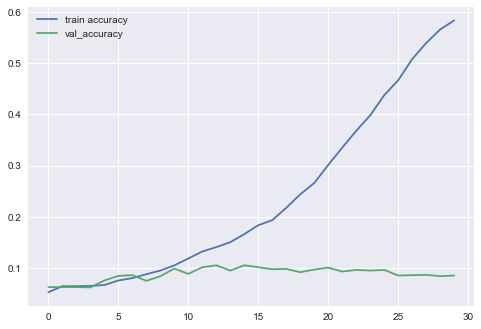

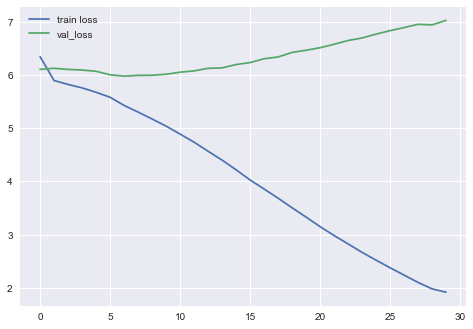

In [14]:
plt.style.use('seaborn')

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.show()

# Use trained model to predict next word

In [13]:
rand_ind = np.random.randint(len(X_test)-training_len)
#rand_ind = 0 # uncomment to specify a start index

seed_seq = X_sorted[rand_ind]
actual_seq = y_sorted[rand_ind : rand_ind+training_len]

pred_seq = np.empty((training_len,))
for i in range(training_len):
    pred_seq[i] = np.argmax(model.predict(np.expand_dims(X_test[rand_ind+i, :], axis=0))[0])
    

print('Seed Sequence: ')
print('\"' + ' '.join([tokenizer.index_word[i] for i in seed_seq]) + '\"')
print('\nPredicted next 50 words: ')
print('\"' + ' '.join([tokenizer.index_word[i] for i in pred_seq]) + '\"')
print('\nActual next 50 words: ')
print('\"' + ' '.join([tokenizer.index_word[i] for i in actual_seq]) + '\"')

Seed Sequence: 
"she heard a little pattering of feet in the distance and she hastily dried her eyes to see what was coming it was the white rabbit returning splendidly dressed with a pair of white kid gloves in one hand and a large fan in the other he came trotting along"

Predicted next 50 words: 
"and the the the hatter the every witness and king as of she of like half voice wish she and of said of was thing a was telescope they whilst a you cross of mouse of the tried the little evidence march to and as and little the it a"

Actual next 50 words: 
"in a great hurry muttering to himself oh the duchess the duchess oh won't she be savage if i've kept her waiting when the rabbit came near her alice began in a low timid voice if you please sir the rabbit started violently dropped the white kid gloves and the"


# Conclusion: NLP is hard :(